Querying, partitioning, and aggregating spatial data are essential tasks in quantitative spatial analysis. In this workflow, we will explore how to query nuclei an tissue segmentation data, partition tissue segmentations, and aggregate spatial grids based on custom heuristics. These workflows enable the analysis of spatial relationships between nuclei and tissue structures, giving insights of spatial distributions of nuclei in relation to surrounding tissues.

Here we demonstrate workflows on:

- **Spatial querying of nuclei with respect to tissue segmentations:**  
    Learn how to identify and extract nuclei of interest (e.g., inflammatory) that are spatially related to specific tissue regions. For example, we can query nuclei that are located within a specific tissue type or region of interest, such as the epithelium or stroma.

- **Partitioning tissue segmentations with to tissue interface regions and spatial grids:**  
    Learn how to divide tissue regions into tissue interfaces and regular grids (hexagonal or rectangular)

- **Aggregating grids based on self defined heuristic:**  
    Learn how to aggregate spatial grids based on custom heuristics, such as the percentage of nuclei with specific class.

These workflows are designed to be flexible and can be adapted to various types of spatially distributed objects in segmented histological images.

Let's start by loading some example data.

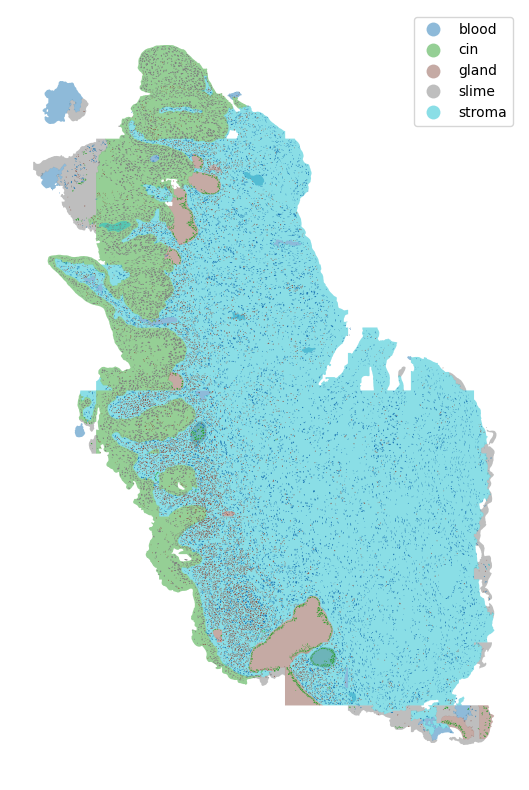

In [1]:
import matplotlib.pyplot as plt
from histolytics.data import cervix_nuclei, cervix_tissue

tis = cervix_tissue()
nuc = cervix_nuclei()

fig, ax = plt.subplots(figsize=(10, 10))
tis.plot(ax=ax, column="class_name", aspect=1, alpha=0.5, legend=True)
nuc.plot(ax=ax, column="class_name", aspect=1, legend=False)
ax.set_axis_off()

## Spatial Querying

To query segmented objects like nuclei within specific tissue regions, the `get_objs`-function can be used. It allows the querying of segmented objects based on their spatial relationship to other objects (e.g., tissue segmentations). The spatial relationship is defined by a spatial predicate (e.g., "within", "intersects", "contains" etc.). Here we will use the function to query for nuclei that are contained within the cervical cin lesion.

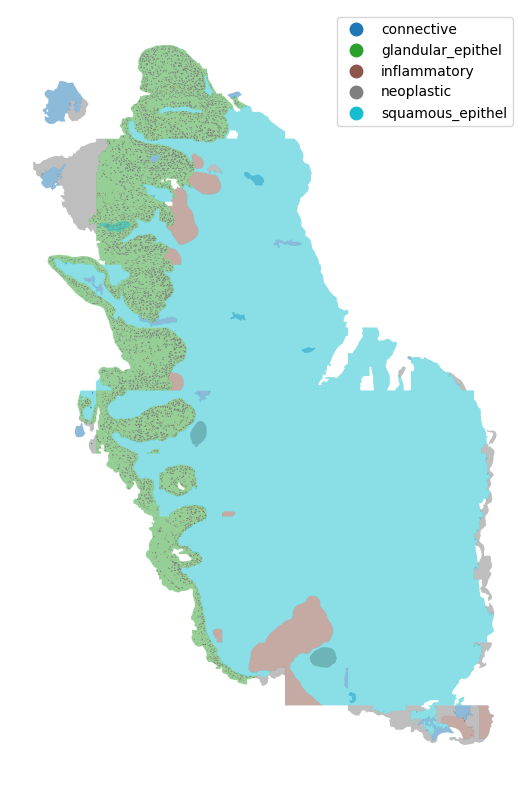

In [2]:
from histolytics.spatial_ops import get_objs

# get the CIN tissue
cin_tissue = tis[tis["class_name"] == "cin"]

# select all the nuclei contained within CIN tissue
nuc_within_cin = get_objs(cin_tissue, nuc, predicate="contains")

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
nuc_within_cin.plot(ax=ax, column="class_name", aspect=1, legend=True)
ax.set_axis_off()


We will select only TILs within the CIN tissue which can be a clinically relevant feature to assess.

In [3]:
nuc_within_cin.value_counts("class_name")

class_name
neoplastic           3501
inflammatory          540
connective              3
glandular_epithel       1
squamous_epithel        1
Name: count, dtype: int64

Visualize the TILs:

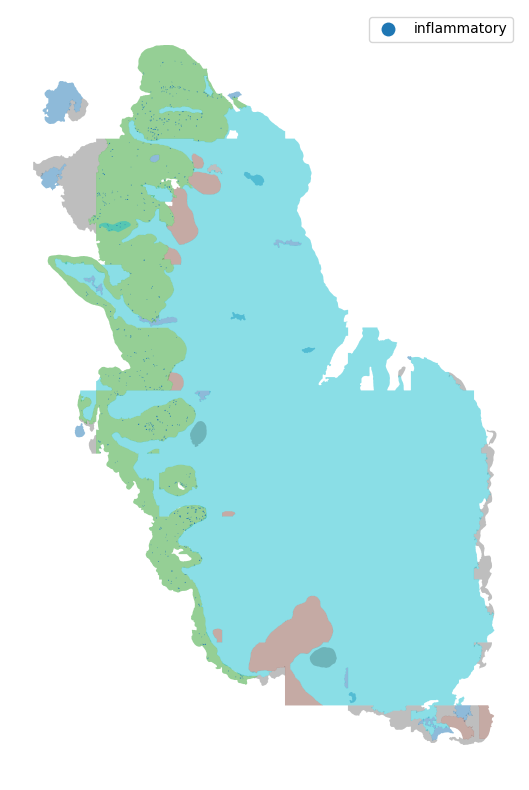

In [4]:
TILS = nuc_within_cin.loc[nuc_within_cin["class_name"] == "inflammatory"]

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
TILS.plot(
    ax=ax,
    column="class_name",
    aspect=1,
    legend=True,
)
ax.set_axis_off()

## Tissue Interfaces

Next we will showcase, how to find interface regions between two tissues. This can be useful, for example, in defining clinically meaningful interface regions, such as the tumor-stroma interface or the invasive margin of a tumor. In this example, we will extract the interface regions between the CIN lesion and the surrounding stroma to define the lesion-stroma-interface. We will do this with the use the `get_interfaces`-function, followed by the `get_objs`-function to query for nuclei located within the interface.

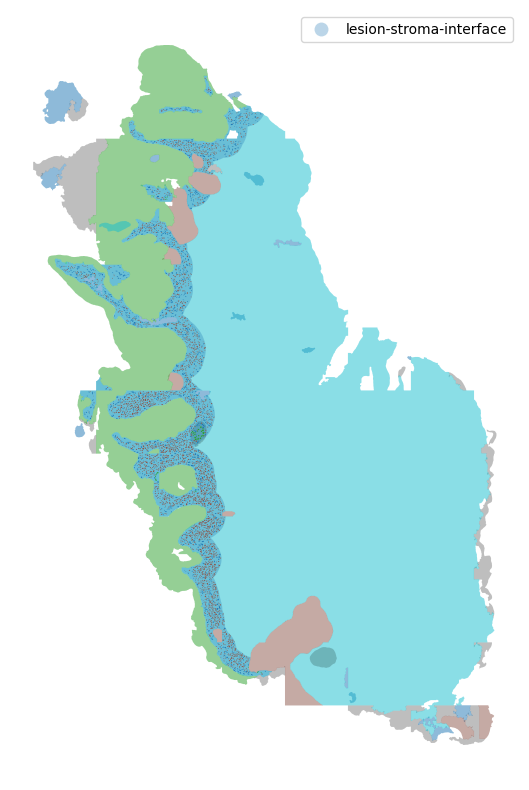

In [5]:
from histolytics.spatial_ops import get_interfaces

stroma = tis[tis["class_name"] == "stroma"]
cin_tissue = tis[tis["class_name"] == "cin"]

interface = get_interfaces(cin_tissue, stroma, buffer_dist=300)
interface = interface.assign(class_name="lesion-stroma-interface")
nuc_within_interface = get_objs(interface, nuc, predicate="contains")

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
interface.plot(ax=ax, column="class_name", aspect=1, alpha=0.3, legend=True)
nuc_within_interface.plot(
    ax=ax,
    column="class_name",
    aspect=1,
    legend=False,
)
ax.set_axis_off()

Let's again select only immune nuclei within the CIN lesion-stroma interface. We call these again TILs (type 2).

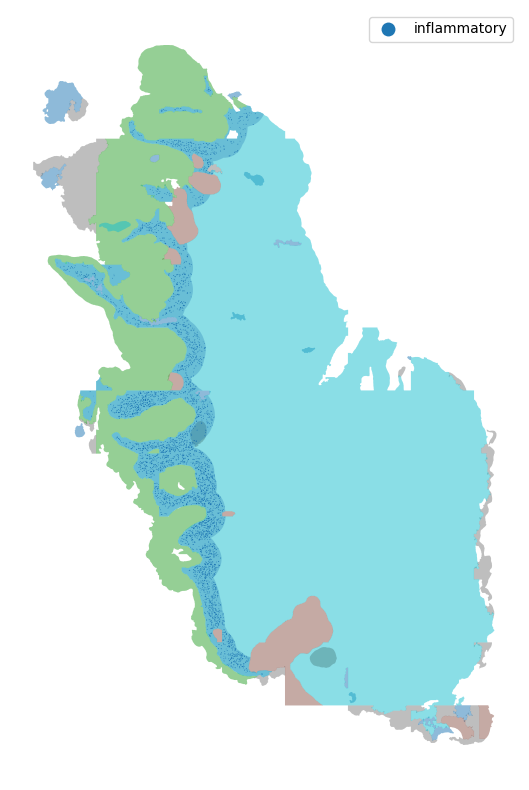

In [6]:
TILS = nuc_within_interface.loc[nuc_within_interface["class_name"] == "inflammatory"]

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
interface.plot(ax=ax, column="class_name", aspect=1, alpha=0.3, legend=True)
TILS.plot(
    ax=ax,
    column="class_name",
    aspect=1,
    legend=True,
)
ax.set_axis_off()

As we see, there is a heavy concentration of TILs at the interface region. This can be a sign of an activated immune response to the CIN lesion.

## Grid Partitioning

To gain more granularity in our spatial analyses, we can partition the tissue segmentations with grids. This allows us to analyze spatial distributions with more detail than with bare tissue segmentations. Histolytics support hierarchical geospatial indices such as H3 and quadbin for this reason. In the next cell, we use H3 hexagonal grid to partition the stromal tissue at different resolutions to get a picture what this looks like.

### H3 Hexagonal Grid Partitioning

We showcase the h3 spatial indexing with three different resolutions. The resolution can be set with the `resolution`-parameter. The higher the resolution, the smaller the hexagons and the more detailed the partitioning.

,geometry
8982a939503ffff,"POLYGON ((6672.79721 859.08743, 6647.90711 661..."
8982a939877ffff,"POLYGON ((2556.61731 5658.46273, 2581.53692 58..."
8982a939c4bffff,"POLYGON ((4546.44516 4059.58249, 4366.53531 39..."
8982a93917bffff,"POLYGON ((6221.15607 3971.09325, 6041.22381 38..."
8982a939a7bffff,"POLYGON ((4399.78122 8249.68626, 4219.8982 815..."


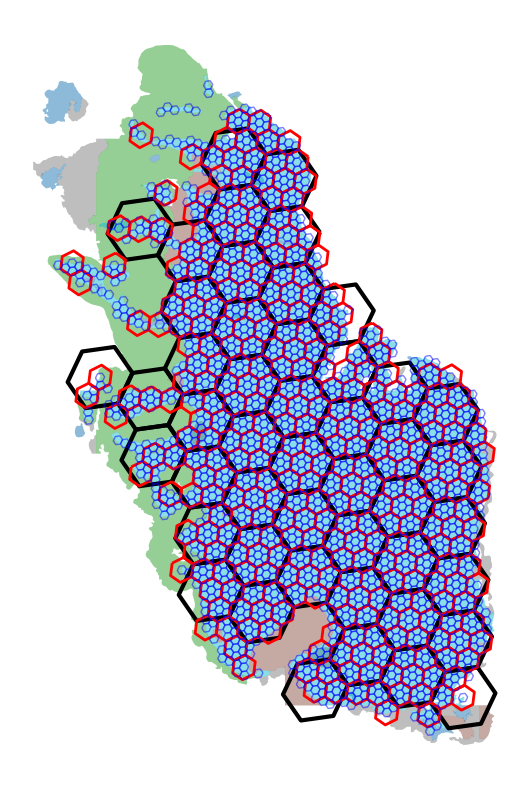

In [7]:
from histolytics.spatial_ops.h3 import h3_grid

h3_res8 = h3_grid(stroma, resolution=8)
h3_res9 = h3_grid(stroma, resolution=9)
h3_res10 = h3_grid(stroma, resolution=10)
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
h3_res8.plot(ax=ax, aspect=1, legend=True, facecolor="none", edgecolor="black", lw=3)
h3_res9.plot(ax=ax, aspect=1, legend=True, facecolor="none", edgecolor="red", lw=2)
h3_res10.plot(
    ax=ax, aspect=1, legend=True, facecolor="none", edgecolor="blue", lw=1, alpha=0.5
)
ax.set_axis_off()

h3_res9.head(5)

### Quadbin Grid

Again, we showcase the quadbin spatial indexing with different resolutions.

,geometry
5271089524171866111,"POLYGON ((6581.37043 761.23896, 6581.36916 608..."
5271089524172062719,"POLYGON ((6734.64415 761.23754, 6734.64288 608..."
5271089524171931647,"POLYGON ((6734.64571 913.48504, 6734.64415 761..."
5271089512657977343,"POLYGON ((2902.84825 4719.89368, 2902.83957 45..."
5271089512691531775,"POLYGON ((2902.74344 2283.81968, 2902.73931 21..."


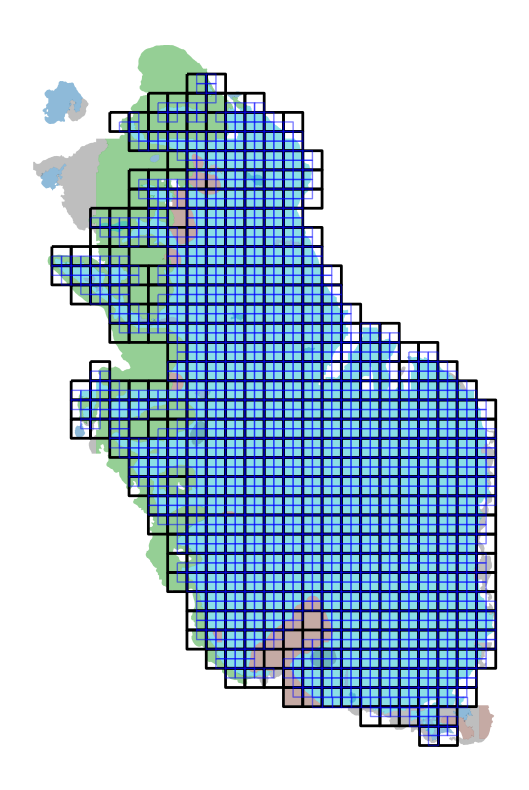

In [8]:
from histolytics.spatial_ops.quadbin import quadbin_grid

quad_grid_res17 = quadbin_grid(stroma, resolution=17)
quad_grid_res18 = quadbin_grid(stroma, resolution=18)

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
quad_grid_res17.plot(
    ax=ax, aspect=1, legend=True, facecolor="none", edgecolor="black", lw=2
)
quad_grid_res18.plot(
    ax=ax, aspect=1, legend=True, facecolor="none", edgecolor="blue", lw=1, alpha=0.5
)
ax.set_axis_off()
quad_grid_res18.head(5)

### Custom Rectangular Grid

You can also use a custom rectangular grid with the xy-resolution of your own choosing and possibility to add overlap to the grid cells. Here we use the 'contains' predicate to constrain grid cells to be strictly within the stroma. Other spatial predicates can be used as well, such as 'intersects' or 'within', "contains_properly.

,geometry
0,"POLYGON ((5443 626, 5699 626, 5699 882, 5443 8..."
1,"POLYGON ((4419 882, 4675 882, 4675 1138, 4419 ..."
2,"POLYGON ((4675 882, 4931 882, 4931 1138, 4675 ..."
3,"POLYGON ((5187 882, 5443 882, 5443 1138, 5187 ..."
4,"POLYGON ((5443 882, 5699 882, 5699 1138, 5443 ..."


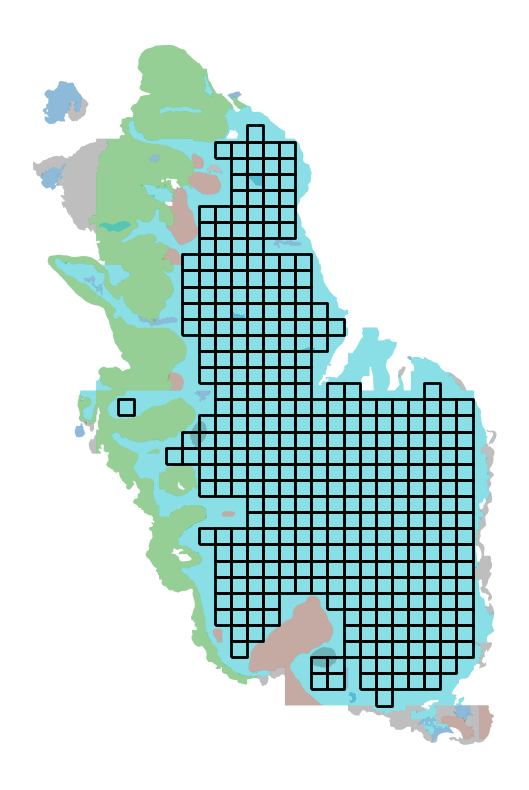

In [9]:
from histolytics.spatial_ops.rect_grid import rect_grid

rect_grid_res256 = rect_grid(
    stroma, resolution=(256, 256), overlap=0, predicate="contains"
)

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
rect_grid_res256.plot(
    ax=ax, aspect=1, legend=True, facecolor="none", edgecolor="black", lw=2
)

ax.set_axis_off()
rect_grid_res256.head(5)

Here we use the 'intersects' predicate where all grid cells that intersect with the stroma are returned.

,geometry
0,"POLYGON ((5955 114, 6211 114, 6211 370, 5955 3..."
1,"POLYGON ((6211 114, 6467 114, 6467 370, 6211 3..."
2,"POLYGON ((6467 114, 6723 114, 6723 370, 6467 3..."
3,"POLYGON ((5187 370, 5443 370, 5443 626, 5187 6..."
4,"POLYGON ((5443 370, 5699 370, 5699 626, 5443 6..."


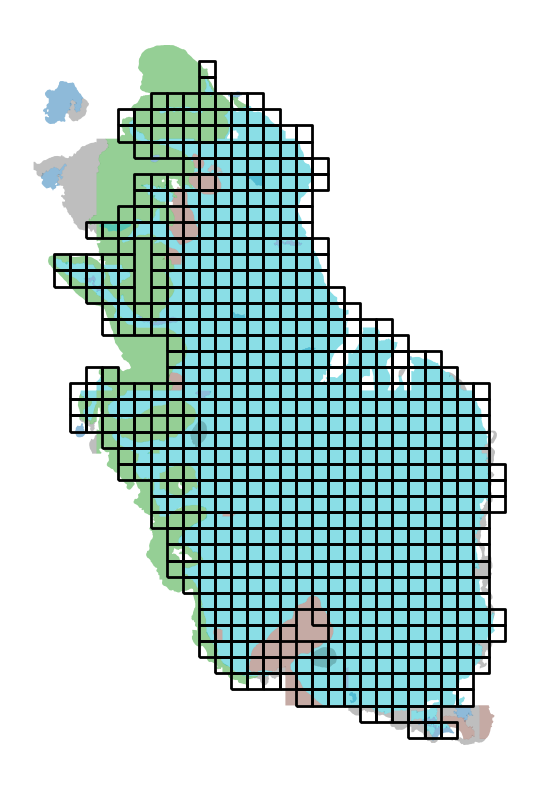

In [10]:
rect_grid_res256 = rect_grid(
    stroma, resolution=(256, 256), overlap=0, predicate="intersects"
)

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
rect_grid_res256.plot(
    ax=ax, aspect=1, legend=True, facecolor="none", edgecolor="black", lw=2
)

ax.set_axis_off()
rect_grid_res256.head(5)

## Grid aggregation and legendgrams

Finally, we can aggregate nuclei related features within the grid cells to get a quantitative overview of the spatial distribution of nuclei in the stroma. This is done using the `grid_aggregate`-function, which allows you to specify the aggregation function (e.g., count, mean).

Here we define a custom aggregation function that counts the percentage of immune cells in each grid cell and we'll visualize the grid based on these values.

We will add a legendgram to the visualization to show the distribution of the percentage of immune cells in the grid cells. The legendgram is a histogram-like representation that shows the distribution of values in the grid cells.

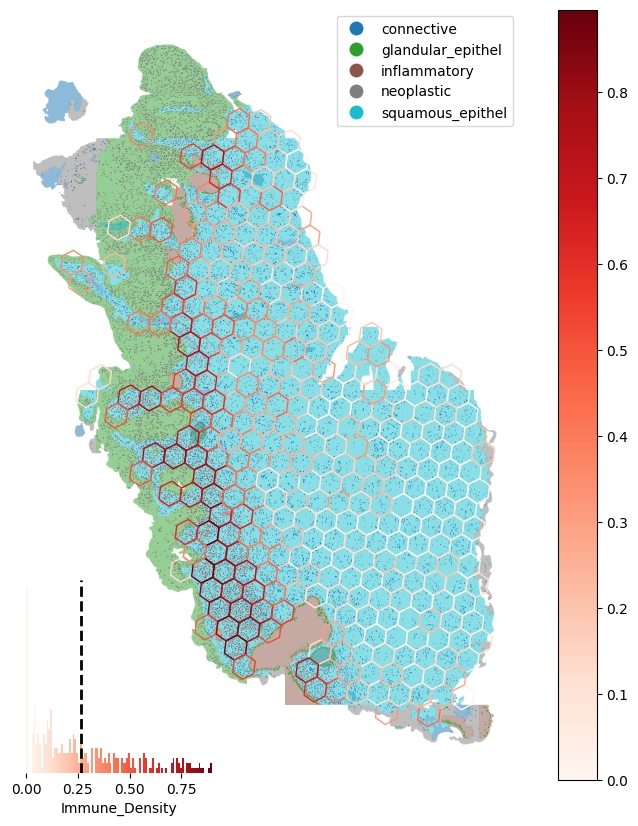

In [25]:
from histolytics.spatial_agg import grid_aggregate
from histolytics.utils.plot import legendgram


# This function will compute the percentage of immune nuclei within each grid cell
# In general, any function that takes a GeoDataFrame and returns a scalar
# can be used here. Typically, this will be a function that calculates
# a count, sum, mean, or other statistic of interest out of the nuclei.
def immune_density(nuclei):
    """Calculate the immune cell count in a grid cell."""
    if "inflammatory" in nuclei.value_counts("class_name"):
        cnt = nuclei.value_counts("class_name", normalize=True)["inflammatory"]
    else:
        cnt = 0
    return float(cnt)


h3_res9 = grid_aggregate(
    objs=nuc,
    grid=h3_res9,
    metric_func=immune_density,
    new_col_names=["immune_density"],
    predicate="contains",
    num_processes=2,
)

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
nuc.plot(ax=ax, column="class_name", aspect=1, legend=True)
h3_res9.plot(
    ax=ax,
    column="immune_density",
    cmap="Reds",
    legend=True,
    aspect=1,
    facecolor="none",
)
ax.set_axis_off()

# Add a legendgram to visualize the distribution of immune cell density
ax = legendgram(
    gdf=h3_res9,
    column="immune_density",
    n_bins=100,
    cmap="Reds",
    ax=ax,
)


Here we see that the immune dense regions are located at the interface between the CIN lesion and the stroma, indicative of immune activation.

## Conclusion
In this workflow, we demonstrated how to query spatially distributed objects in segmented histological images, partition tissue segmentations with grids, and aggregate spatial grids based on custom heuristics. These workflows enable the analysis of spatial relationships between cells and tissue structures, facilitating insights into tissue architecture and cellular distributions. The flexibility of the `get_objs`, `get_interfaces`, and `grid_aggregate` functions allows for a wide range of spatial analyses tailored to specific research questions in histology.